In [1]:
%reload_ext autoreload
%autoreload 2
from itertools import chain
from os import listdir
from collections import defaultdict
from NaiveBayes import MultinomialNaiveBayes
from preprocessing import bag_of_words
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [2]:
folds = sorted([(int(a[4:]), []) for a in listdir('pu1/') if a[0] != '.'])

In [3]:
for fold in folds:
    d = 'pu1/part{}/'.format(fold[0])
    for f_name in listdir(d):
        with open(d + f_name) as f:
            lines = [line.rstrip('\n') for line in f]
            subj = lines[0].lstrip('Subject: ')
            text = lines[2:][0]
            fold[1].append([f_name.find('spm') >= 0, subj, text])
folds = [l for (ignore, l) in folds]

In [4]:
bigfold = list(chain(*folds[1:]))

In [28]:
def make_test(num_test):
    bigfold = list(chain(*folds[:num_test], *folds[num_test + 1:]))
    test = folds[num_test]
    texts = [bag_of_words(a[2]) for a in bigfold]
    subjects = [bag_of_words(a[1]) for a in bigfold]
    y = [a[0] for a in bigfold]
    x = []
    for (i, t) in enumerate(texts):
        x.append({k: t.get(k, 0) + subjects[i].get(k, 0) * 1.2 for k in set(t) | set(subjects[i])})
    test = folds[0]
    t_text = [bag_of_words(a[2]) for a in test]
    t_subj = [bag_of_words(a[1]) for a in test]
    t_y = [a[0] for a in test]
    t_x = []
    for (i, t) in enumerate(t_text):
        t_x.append({ k: t.get(k, 0) + t_subj[i].get(k, 0) * 1.2 for k in set(t) | set(t_subj[i]) })
    return (x, y, t_x, t_y)

In [32]:
bord = -10000

In [38]:
def score(X, y, bayes):
        global bord
        
        res = [0, 0]
        predict = []
        answer = []
        for (i,x) in enumerate(X):
            if y[i] == 1:
                bord = max(bord, sum((bayes._probs[1].get(k, bayes._alpha) * v for (k,v) in x.items())))
            res[y[i]] += bayes.predict(X[i]) != y[i]
            predict.append(bayes.predict(X[i]))
            answer.append(y[i])
        return res, f1_score(predict, answer)

In [40]:
print(bord)

-170.631003814


In [41]:
f1_sum = 0
for i in range(len(folds)):
    x, y, t_x, t_y = make_test(i)
    bayes = MultinomialNaiveBayes(10**-7, -170.631)
    bayes.fit(x, y)
    misses, f1 = score(t_x, t_y, bayes)
    print("Spam is Legit", misses[0])
    print("Legit is Spam", misses[1])
    print("F1 ", f1)
    f1_sum += f1
print('Avg F1 score: {}'.format(f1_sum / len(folds)))

Spam is Legit 0
Legit is Spam 10
F1  0.883720930233
Spam is Legit 0
Legit is Spam 8
F1  0.909090909091
Spam is Legit 0
Legit is Spam 5
F1  0.945054945055
Spam is Legit 0
Legit is Spam 8
F1  0.909090909091
Spam is Legit 0
Legit is Spam 8
F1  0.909090909091
Spam is Legit 0
Legit is Spam 6
F1  0.933333333333
Spam is Legit 0
Legit is Spam 8
F1  0.909090909091
Spam is Legit 0
Legit is Spam 7
F1  0.921348314607
Spam is Legit 0
Legit is Spam 8
F1  0.909090909091
Spam is Legit 0
Legit is Spam 6
F1  0.933333333333
Avg F1 score: 0.9162245402015458


AUC: 0.9255464480874322


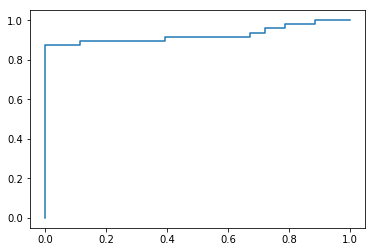

In [42]:
x, y, t_x, t_y = make_test(1)
roc = [(0, 0)]
pos = len([y_i for y_i in t_y if y_i == 1])
neg = len([y_i for y_i in t_y if y_i == 0])
bayes = MultinomialNaiveBayes(10**-7, -170.631)
bayes.fit(x, y)
auc = 0
xy = sorted(list(zip(t_x, t_y)), key=lambda e: not bayes.predict(e[0]))
for (x_pr, y_pr) in xy:
    if y_pr == 0:
        roc.append((roc[-1][0] + 1.0 / neg, roc[-1][1]))
        auc += roc[-1][1] / neg
    else:
        roc.append((roc[-1][0], roc[-1][1] + 1.0 / pos))
print('AUC: {}'.format(auc))
plt.plot(*zip(*roc))
plt.show()
    